[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-aps.ipynb)

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

## [Click this link](https://github.com/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-raps.ipynb) for a version of APS with much-improved practical performance.

In [2]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
if not os.path.exists('../data/imagenet/human_readable_labels.json'):
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

In [3]:
# Problem setup
n=1000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage

In [4]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]

### Conformal prediction happens here

In [5]:
# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
cal_pi = cal_smx.argsort(1)[:,::-1]; cal_srt = np.take_along_axis(cal_smx,cal_pi,axis=1).cumsum(axis=1)
cal_scores = np.take_along_axis(cal_srt,cal_pi.argsort(axis=1),axis=1)[range(n),cal_labels]
# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
# Deploy (output=list of length n, each element is tensor of classes)
val_pi = val_smx.argsort(1)[:,::-1]; val_srt = np.take_along_axis(val_smx,val_pi,axis=1).cumsum(axis=1)
prediction_sets = np.take_along_axis(val_srt <= qhat,val_pi.argsort(axis=1),axis=1)

In [6]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.8976122448979592


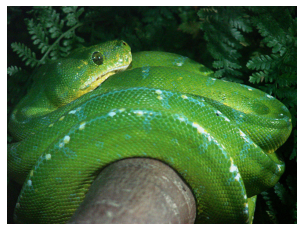

The prediction set is: ['eastern hog-nosed snake', 'smooth green snake', 'kingsnake', 'vine snake', 'night snake', 'boa constrictor', 'African rock python', 'green mamba', 'sea snake', 'Saharan horned viper', 'sidewinder']


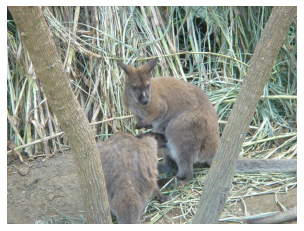

The prediction set is: ['wallaby']


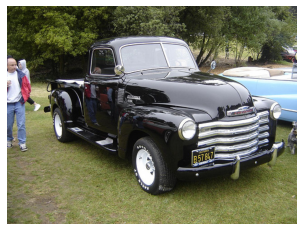

The prediction set is: ['station wagon', 'taxicab', 'car wheel', 'convertible', 'grille', 'jeep', 'limousine', 'Model T', 'pickup truck', 'tow truck']


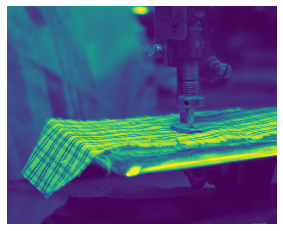

The prediction set is: ['clothes iron', 'nail', 'power drill', 'screw', 'sewing machine']


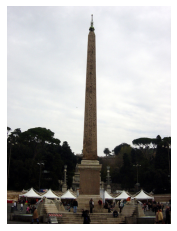

The prediction set is: ['obelisk', 'pedestal']


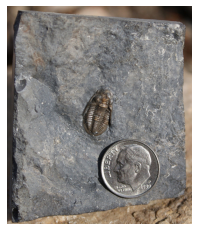

The prediction set is: ['trilobite', 'chiton', 'isopod', 'cockroach', 'armadillo']


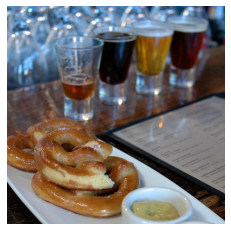

The prediction set is: ['bagel', 'pretzel']


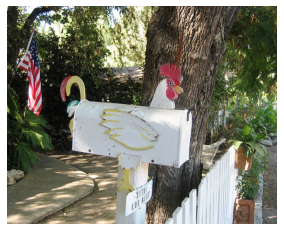

The prediction set is: ['birdhouse', 'mailbox', 'padlock', 'picket fence', 'split-rail fence']


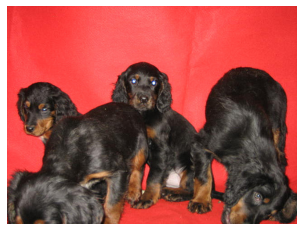

The prediction set is: ['Black and Tan Coonhound', 'English Setter', 'Irish Setter', 'Gordon Setter', 'Cocker Spaniels']


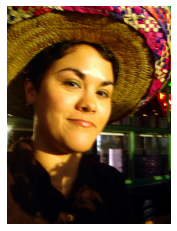

The prediction set is: ['cowboy hat', 'sombrero']


In [7]:
# Show some examples
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples')
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread('../data/imagenet/examples/' + rand_path )
    img_index = int(rand_path.split('.')[0])
    prediction_set = smx[img_index] > 1-qhat
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")

This method was first introduced in https://arxiv.org/abs/2006.02544 and studied further for image classifiers in https://arxiv.org/abs/2009.14193.